# Batting Basic Modeling

In [3]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

np.random_state = 42

In [4]:
# load batting_basic
batting_basic = pd.read_csv('Data/batting_basic', index_col = 0)
batting_basic = batting_basic.drop(columns = ['Season', 'Name'])
batting_basic.head()

,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,OF,CHW,27.0,255000.0,394926.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,2B,NYM,31.0,500000.0,774365.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,OF,MIA,24.0,327000.0,430203.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,2B,TBR,23.0,215000.0,321031.0,79.0,304.0,335.0,0.270,82.0,59.0,17.0,1.0,5.0,43.0,33.0,27.0,1.0,35.0,0.0,1.0,3.0,3.0,8.0,3.0,0.328,0.382,0.710
4,2B,TBR,24.0,215000.0,317237.0,117.0,463.0,504.0,0.242,112.0,88.0,18.0,4.0,2.0,46.0,40.0,25.0,0.0,46.0,6.0,2.0,8.0,8.0,10.0,4.0,0.288,0.311,0.599


## Checking Correlations Between Features

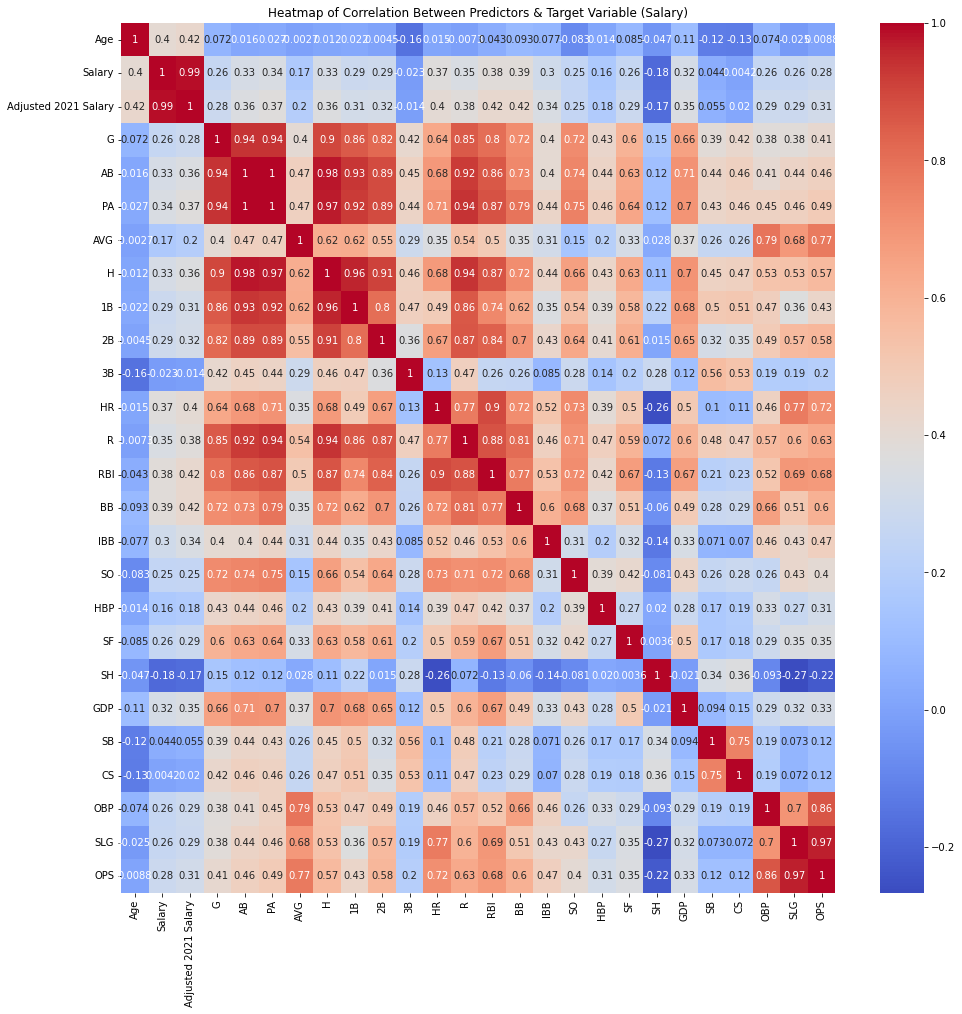

In [5]:
# set up figure size
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = batting_basic.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Salary)");

plt.show()

We see that from this correlation map, that many of the basic hitting stats are highly correlated with each other (highlighted by the red in the upper left). 

Additionally, we see that some of the stats such as OBP, SLG, and OPS are also highly correlated with each other as expected (OPS is the sum of OBP and SLG). 

## Feature Selection

**Multicollinearity**

In [6]:
corr_df = batting_basic.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
corr_df.drop_duplicates(inplace=True)

In [7]:
corr_df[(corr_df.cc>0.9) & (corr_df.cc <1)]

,cc
pairs,
"(PA, AB)",0.996289
"(Adjusted 2021 Salary, Salary)",0.989199
"(H, AB)",0.975935
"(PA, H)",0.972980
"(SLG, OPS)",0.965462
"(H, 1B)",0.963932
"(R, H)",0.937833
"(PA, G)",0.937455
"(PA, R)",0.936717


Lots of collinear features. We will selectively remove the top offenders where the features are most collinearly related with each other.

**Feature Selection Using `feature_selection`**

In [8]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, mutual_info_regression

In [9]:
feature_selector = SelectKBest(mutual_info_regression, k = 6)

In [10]:
df = batting_basic[['Age', 'G', 'AVG', 'H', '1B', '2B',
       '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP',
       'SB', 'CS', 'OBP', 'SLG', 'OPS']]

In [11]:
feature_selector.fit(df, batting_basic['Adjusted 2021 Salary'])

# get top features
df.columns[feature_selector.get_support()]

Index(['Age', 'H', 'HR', 'R', 'RBI', 'BB'], dtype='object')

### Grouping by Name and Averages
During the modeling process, we observed that while we have more rows of data for the `batting_basic` table, it is extremely difficult for the model to determine a projected player's salary since we are considering many different rows for the same player for multiple years. 

Lets simplify the model even further by grouping `batting_basic` by player names and determining the average of every other feature. 

In [12]:
bb_grouped = pd.read_csv('Data/batting_basic', index_col = 0)

In [13]:
# group by Name and find averages across all other features
bb_grouped = bb_grouped.groupby(['Name']).mean()
bb_grouped = bb_grouped.drop(columns = 'Season')
bb_grouped.head()

,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
Name,,,,,,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,33.0,2.125778e+06,2.359374e+06,73.333333,215.000000,254.444444,0.242667,51.666667,37.333333,9.111111,0.333333,4.888889,21.444444,25.333333,31.111111,2.444444,45.666667,3.111111,2.000000,3.222222,7.444444,0.222222,0.444444,0.344556,0.349778,0.694333
Aaron Altherr,25.5,5.326250e+05,5.788645e+05,77.000000,237.500000,271.250000,0.224000,54.500000,30.000000,13.000000,2.500000,9.000000,33.500000,37.000000,26.750000,1.000000,76.250000,5.500000,1.250000,0.250000,8.000000,5.250000,2.500000,0.319250,0.407750,0.727000
Aaron Boone,31.0,1.896875e+06,2.617539e+06,116.125000,394.500000,442.500000,0.263500,102.750000,65.750000,22.000000,1.250000,13.750000,54.250000,56.250000,32.000000,2.125000,73.125000,8.250000,3.625000,3.750000,8.000000,10.375000,2.875000,0.331000,0.425125,0.756000
Aaron Cunningham,25.0,4.823000e+05,5.694040e+05,59.000000,106.333333,119.000000,0.213667,23.666667,14.000000,7.333333,0.666667,1.666667,11.333333,10.333333,8.333333,0.666667,23.333333,1.333333,1.333333,1.666667,1.666667,0.666667,2.000000,0.277667,0.343667,0.621667
Aaron Guiel,30.5,3.200000e+05,4.549862e+05,61.000000,209.500000,237.000000,0.240000,51.750000,31.750000,13.000000,0.000000,7.000000,31.500000,27.500000,17.250000,0.500000,46.750000,6.250000,2.750000,1.250000,3.000000,1.500000,2.750000,0.315000,0.393250,0.708000


## Train-Test Split

Define the X as features we want to keep for the Train-Test Split

**Splitting the Batting Basic**

In [14]:
batting_basic.columns

Index(['POS', 'Team', 'Age', 'Salary', 'Adjusted 2021 Salary', 'G', 'AB', 'PA',
       'AVG', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO',
       'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'OBP', 'SLG', 'OPS'],
      dtype='object')

In [15]:
# feature selection, target variable = 'Adjusted 2021 Salary'
X = batting_basic[['POS', 'Team', 'Age', 'H', 'R', 'RBI', 'BB', 'SO',
                   'SF', 'SH', 'GDP', 'SB', 'OPS']]

y = batting_basic['Adjusted 2021 Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [16]:
X_train.head(3)

,POS,Team,Age,H,R,RBI,BB,SO,SF,SH,GDP,SB,OPS
3540,1B,TEX,30.0,35.0,25.0,10.0,13.0,34.0,0.0,7.0,5.0,5.0,0.523
8431,SS,WSN,25.0,180.0,103.0,73.0,69.0,132.0,0.0,2.0,7.0,43.0,0.760
2707,C,BAL,31.0,61.0,30.0,19.0,21.0,56.0,1.0,3.0,7.0,1.0,0.590


**Splitting the Batting Basic Grouped**

In [17]:
bb_grouped.columns

Index(['Age', 'Salary', 'Adjusted 2021 Salary', 'G', 'AB', 'PA', 'AVG', 'H',
       '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF',
       'SH', 'GDP', 'SB', 'CS', 'OBP', 'SLG', 'OPS'],
      dtype='object')

In [18]:
# feature selection, target variable = 'Adjusted 2021 Salary'
X = bb_grouped[['Age', 'H', 'R', 'RBI', 'BB', 'SO',
               'SF', 'SH', 'GDP', 'SB', 'OPS']]
y = bb_grouped['Adjusted 2021 Salary']
grouped_X_train, grouped_X_test, grouped_y_train, grouped_y_test = train_test_split(X, y, random_state= 42)

In [19]:
grouped_X_train.head(3)

,Age,H,R,RBI,BB,SO,SF,SH,GDP,SB,OPS
Name,,,,,,,,,,,
Jordan Schafer,24.8,56.0,32.4,16.0,28.4,72.0,0.6,4.6,2.2,20.6,0.6214
Midre Cummings,28.0,57.0,29.0,24.0,17.0,28.0,0.0,1.0,5.0,0.0,0.7240
Angel Berroa,27.2,124.8,60.6,48.2,20.8,84.8,3.0,8.6,14.0,9.0,0.6736


In [20]:
X_train_corr_df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
X_train_corr_df['pairs'] = list(zip(X_train_corr_df.level_0, X_train_corr_df.level_1))

# set index to pairs
X_train_corr_df.set_index(['pairs'], inplace = True)

#drop level columns
X_train_corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
X_train_corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
X_train_corr_df.drop_duplicates(inplace=True)

In [21]:
X_train_corr_df[(X_train_corr_df.cc>0.75) & (X_train_corr_df.cc <1)].head()

,cc
pairs,
"(H, R)",0.938091
"(R, RBI)",0.876304
"(H, RBI)",0.870976
"(BB, R)",0.810773
"(BB, RBI)",0.767703


In [22]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6854, 13)
(2285, 13)
(6854,)
(2285,)


In [23]:
print(grouped_X_train.shape)
print(grouped_X_test.shape)
print(grouped_y_train.shape)
print(grouped_y_test.shape)

(1381, 11)
(461, 11)
(1381,)
(461,)


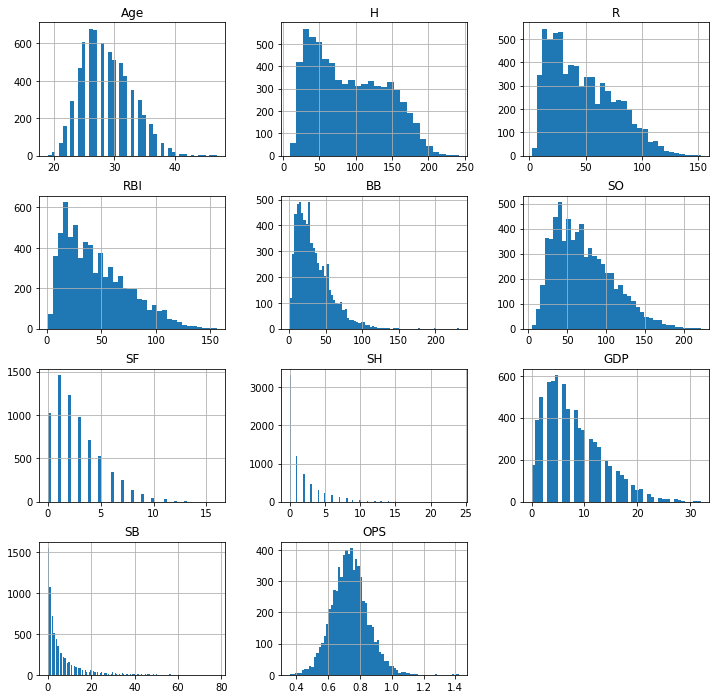

In [24]:
# check distribution of features
X_train.hist(figsize = [12,12], bins = 'auto')
plt.show()

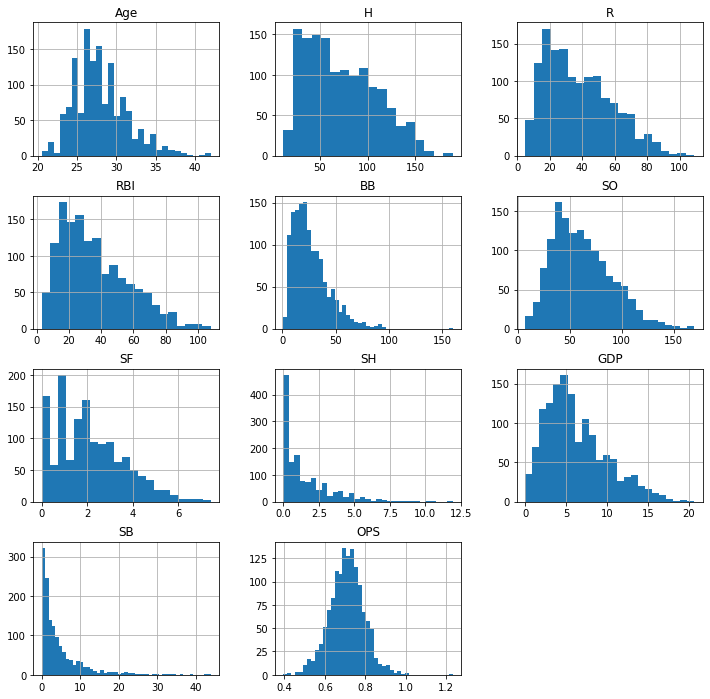

In [25]:
grouped_X_train.hist(figsize = [12,12], bins = 'auto')
plt.show()

## Preprocessing Pipeline (Removing Multicolinear Features)
Note: The new column transformer `bb_ct_2` performs a column transformation on the X features we want to keep after feature selection. 

In [26]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [27]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler()), # apply a standard scaler
#                              ('poly', PolynomialFeatures(interaction_only = True # interactions 
#                                                          )) 
                             ])

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                                         sparse = False))]) 

In [28]:
# transform the selected columns with nominal, and numeric pipelines
bb_ct_2 = ColumnTransformer(transformers = 
                    [("nominalpipe", nominal_pipeline, cat_cols), 
                     ("numpipe", numeric_pipeline, num_cols)])

In [29]:
# transform the selected columns with numeric pipelines (for grouped set ONLY)
bb_ct_3 = ColumnTransformer(transformers = 
                    [("numpipe", numeric_pipeline, num_cols)])

### Pickle the Transformers

In [30]:
# save the transformer
dump(bb_ct_2, open('pkl/bb_ct_2.pkl', 'wb'))

# save the grouped transformer
dump(bb_ct_3, open('pkl/bb_ct_3.pkl', 'wb'))

In [31]:
# load the transformer
bb_ct_2 = load(open('pkl/bb_ct_2.pkl', 'rb'))
bb_ct_3 = load(open('pkl/bb_ct_3.pkl', 'rb'))

**Transform `batting_basic`**

In [32]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_bb_X_train = pd.DataFrame(bb_ct_2.fit_transform(X_train))
pp_bb_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.308498,-1.128853,-0.789194,-1.207010,-0.889137,-0.986358,-1.173483,2.080911,-0.520379,-0.100567,-1.878270
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.917267,1.774726,1.949165,0.936743,1.529448,1.637258,-1.173483,0.134282,-0.153983,4.315700,0.215500
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553651,-0.608211,-0.613658,-0.900759,-0.543625,-0.397383,-0.752183,0.523608,-0.153983,-0.565437,-1.286361
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553651,1.434307,1.352343,1.072855,-0.241301,0.218364,0.511720,0.523608,2.044389,1.061608,0.127155
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553651,-0.708335,-0.087051,-0.118119,1.097558,-0.102895,-1.173483,-0.644370,0.212412,-0.565437,1.151954


In [33]:
pp_bb_X_train.shape

(6854, 48)

Now lets do the same transformation for the `X_test`

In [34]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_bb_X_test = pd.DataFrame(bb_ct_2.transform(X_test))
pp_bb_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.181808,1.093887,0.509771,0.528409,0.147400,0.673481,3.039525,0.134282,0.578807,1.177826,0.471700
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308498,1.634554,1.282129,0.120075,0.967991,-0.343839,-0.330882,2.859563,1.128401,2.223784,-0.067203
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.289109,-0.948631,-1.245587,-1.241038,-1.105082,-1.093444,-0.752183,1.302259,-1.253170,-0.681655,-0.968320
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.672114,-0.668285,-0.473230,-0.798676,-0.414058,0.111277,-0.330882,-0.644370,-0.703577,0.596738,-1.427712
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308498,-0.508088,-0.789194,-0.458398,-0.414058,-0.691870,0.090419,-0.644370,-0.153983,-0.681655,-0.729789


In [35]:
pp_bb_X_test.shape

(2285, 48)

**Transform `bb_grouped`**

In [36]:
# inspect the preprocessed grouped X train aka pp_grp_X_train
pp_grp_X_train = pd.DataFrame(bb_ct_3.fit_transform(grouped_X_train))
pp_grp_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.951729,-0.459441,-0.264749,-0.939258,0.093108,0.348318,-1.030872,1.665541,-1.057451,2.695093,-1.010112
1,0.002708,-0.431858,-0.432932,-0.558447,-0.577159,-1.190387,-1.433609,-0.298941,-0.315724,-0.775878,0.172999
2,-0.235901,1.438285,1.130184,0.593506,-0.353737,0.795941,0.580076,3.848299,2.068399,0.740566,-0.408178
3,-0.593815,2.080723,1.581671,1.912496,1.197391,1.473735,0.946201,-0.695806,1.972071,0.388261,0.716019
4,-0.892076,1.282242,1.248902,1.121201,0.917922,1.232574,0.388296,-0.688719,1.122318,1.125694,1.253647


In [37]:
# inspect the preprocessed grouped X train aka pp_grp_X_test
pp_grp_X_test = pd.DataFrame(bb_ct_3.transform(grouped_X_test))
pp_grp_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.742946,-0.776648,-0.816291,-0.332341,-0.253785,0.033583,-0.426767,-0.844631,-0.381949,-0.775878,0.011561
1,-0.295553,-1.617937,-1.273849,-1.415271,-0.988726,-0.980563,-1.433609,-0.844631,-0.845529,-0.775878,-2.732888
2,-0.096712,-0.358303,-0.202092,-0.399776,-0.694750,0.016098,-0.203024,0.428645,-0.801378,-0.073820,0.169156
3,0.168409,0.803257,0.402489,1.075866,0.030393,-0.483204,1.400466,-0.662734,1.832930,-0.476333,0.629126
4,-0.593815,-0.921460,-0.915223,-0.677450,-0.988726,-0.482233,-0.762381,0.383171,-0.845529,-0.733754,-0.657254


**Log Transforming Salary**

In [38]:
# basic y
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# grouped y
log_grp_y_train = np.log(grouped_y_train)
log_grp_y_test = np.log(grouped_y_test)

## Feature Selection

**Multicollinearity**

In [39]:
corr_df = pp_bb_X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
corr_df.drop_duplicates(inplace=True)

In [40]:
corr_df[(corr_df.cc>.5) & (corr_df.cc <1)]

,cc
pairs,
"(39, 38)",0.938091
"(40, 39)",0.876304
"(40, 38)",0.870976
"(41, 39)",0.810773
"(41, 40)",0.767703
"(38, 41)",0.723939
"(40, 42)",0.718251
"(39, 42)",0.714295
"(38, 45)",0.705555


## Modeling

In [41]:
# import my helper function to get model results
from functions import *

### Linear Regression

**Batting Basic Model**

In [42]:
# build pipeline 
steps = [('preprocess', bb_ct_2), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['POS', 'Team'], dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SF', 'SH', 'GDP', 'SB', 'OPS'], dtype='object'))])),
                ('model', LinearRegression())])

In [43]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_bb_X_train, log_y_train, pp_bb_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.5084
LinearRegression() Test R2:                   0.4912
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5016
LinearRegression() Cross Validation RMSE:    4422404
-------------------------------------------------------
LinearRegression() Training RMSE:            4866150
LinearRegression() Test RMSE:                5106727


**Batting Grouped Model**

In [45]:
# build pipeline 
steps = [('preprocess', bb_ct_3), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(grouped_X_train, log_grp_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SF', 'SH', 'GDP', 'SB', 'OPS'], dtype='object'))])),
                ('model', LinearRegression())])

In [46]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.6176
LinearRegression() Test R2:                   0.6376
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.6051
LinearRegression() Cross Validation RMSE:    2326689
-------------------------------------------------------
LinearRegression() Training RMSE:            2359587
LinearRegression() Test RMSE:                2021986


## PCA

In [147]:
from sklearn.decomposition import PCA

In [171]:
pca = PCA(n_components=.95) # Check out how `n_components` works

X_train_pca2 = pca.fit_transform(pp_grp_X_train)
X_test_pca2 = pca.transform(pp_grp_X_test)

In [173]:
lr_pca = LinearRegression()

# get model results
model_results(lr_pca, X_train_pca2, log_grp_y_train, X_test_pca2, log_grp_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.6048
LinearRegression() Test R2:                   0.626
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5962
LinearRegression() Cross Validation RMSE:    2434107
-------------------------------------------------------
LinearRegression() Training RMSE:            2297289
LinearRegression() Test RMSE:                2091112


In [74]:
lr_pca.coef_

array([ 0.0306549 , -0.03371834,  0.00330794, -0.0881727 ,  0.01896315,
        0.04308905, -0.05772851, -0.03349952,  0.15417961,  0.01917185,
       -0.05815214, -0.0095299 , -0.00066115,  0.01295642, -0.0282417 ,
        0.03153609,  0.00778868,  0.00506005,  0.01298345,  0.01167943,
        0.04066201,  0.02528932,  0.00327376, -0.03605921, -0.00271874,
       -0.01057467,  0.01801517,  0.03151808,  0.0016709 ,  0.12413187,
       -0.00657321, -0.11446665,  0.01044196,  0.00735759, -0.02512599,
        0.00666897,  0.0106841 ,  0.07460177, -0.02784258])

### Support Vector Machine

In [49]:
from sklearn import svm
from sklearn.svm import LinearSVR

**Batting Grouped Model**

In [159]:
# build pipeline 
svm_steps = [('preprocess', bb_ct_3),
            ('model', svm.SVR())]

svm_pipeline = Pipeline(svm_steps)

# define parameters in the grid
svm_grid = {
            'model__kernel': ['rbf', 'linear', 'sigmoid'],
            'model__C': [0.1, 1, 10]
           }  

# get best R2 score from grid search
svm_model = GridSearchCV(estimator = svm_pipeline,
                         param_grid = svm_grid,
                         scoring = 'r2')


# fit and give me the best params
svm_model.fit(grouped_X_train, log_grp_y_train)
display(svm_model.best_params_)
print("Best CV Score:", round(svm_model.best_score_,5))

{'model__C': 1, 'model__kernel': 'rbf'}

Best CV Score: 0.63296


In [160]:
# instantiate the model
best_model = svm_model.best_estimator_
svm_model = best_model.steps[1][1]  # gets the class name of the model

# get model results
model_results(svm_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             SVR(C=1) RESULTS
SVR(C=1) Training R2:               0.7012
SVR(C=1) Test R2:                   0.6565
-------------------------------------------------------
SVR(C=1) Cross Validation R2:       0.6329
SVR(C=1) Cross Validation RMSE:    3922099
-------------------------------------------------------
SVR(C=1) Training RMSE:            1928800
SVR(C=1) Test RMSE:                2084712


### Gradient Boosting Regressor

In [156]:
from sklearn.ensemble import GradientBoostingRegressor

In [166]:
# build pipeline 
ensemble_steps = [('preprocess', bb_ct_3), 
                  ('model', GradientBoostingRegressor(random_state = 42))]

ensemble_pipeline = Pipeline(ensemble_steps)

# define parameters in the grid
ensemble_grid = {
                'model__learning_rate': [0.1],
                'model__n_estimators': [200],
                'model__max_depth': [3]
               }  

# get best R2 score from grid search
ensemble_model = GridSearchCV(estimator = ensemble_pipeline,
                         param_grid = ensemble_grid,
                         scoring = 'r2')

# fit and give me the best params
ensemble_model.fit(grouped_X_train, log_grp_y_train)
display(ensemble_model.best_params_)
print("Best CV Score:", round(ensemble_model.best_score_,5))

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 200}

Best CV Score: 0.60897


In [167]:
# instantiate the model
best_model = ensemble_model.best_estimator_
ensemble_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(ensemble_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             GradientBoostingRegressor(n_estimators=200, random_state=42) RESULTS
GradientBoostingRegressor(n_estimators=200, random_state=42) Training R2:               0.8408
GradientBoostingRegressor(n_estimators=200, random_state=42) Test R2:                   0.6575
-------------------------------------------------------
GradientBoostingRegressor(n_estimators=200, random_state=42) Cross Validation R2:       0.6079
GradientBoostingRegressor(n_estimators=200, random_state=42) Cross Validation RMSE:    2257624
-------------------------------------------------------
GradientBoostingRegressor(n_estimators=200, random_state=42) Training RMSE:            1522037
GradientBoostingRegressor(n_estimators=200, random_state=42) Test RMSE:                1916478


### Random Forest

In [168]:
from sklearn.ensemble import RandomForestRegressor

In [178]:
# build pipeline 
rfr_steps = [('preprocess', bb_ct_3), 
            ('model', RandomForestRegressor(random_state = 42))]

rfr_pipeline = Pipeline(rfr_steps)

# define parameters in the grid
rfr_grid = {'model__n_estimators': [300],
            'model__max_depth': [5],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [2],
            'model__max_features': ['sqrt']}  

# get best R2 score from grid search
rfr_model = GridSearchCV(estimator = rfr_pipeline,
                           param_grid = rfr_grid,
                           scoring = 'r2')

# fit and give me the best params
rfr_model.fit(grouped_X_train, log_grp_y_train)
rfr_model.best_params_
display(rfr_model.best_params_)
print("Best CV Score:", round(rfr_model.best_score_,5))

{'model__max_depth': 5,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 2,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

Best CV Score: 0.6256


In [176]:
# instantiate the model
best_model = rfr_model.best_estimator_
rfr_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(rfr_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) RESULTS
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Training R2:               0.705
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Test R2:                   0.6437
-------------------------------------------------------
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Cross Validation R2:       0.6258
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Cross Validation RMSE:    2166622
-------------------------------------------------------
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples

In [179]:
# instantiate the model
best_model = rfr_model.best_estimator_
rfr_pca_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(rfr_pca_model, X_train_pca2, log_grp_y_train, X_test_pca2, log_grp_y_test)

             RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) RESULTS
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Training R2:               0.6468
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Test R2:                   0.5862
-------------------------------------------------------
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Cross Validation R2:       0.5793
RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=300, random_state=42) Cross Validation RMSE:    2318888
-------------------------------------------------------
RandomForestRegressor(max_depth=5, max_features='sqrt', min_sample

### CatBoost

In [180]:
from catboost import CatBoostRegressor

In [189]:
# build pipeline 
cbr_steps = [('preprocess', bb_ct_3), 
            ('model', CatBoostRegressor(random_state = 42, 
                                        allow_writing_files=False,
                                        verbose = False))]

cbr_pipeline = Pipeline(cbr_steps)

# define parameters in the grid
cbr_grid = {
                'model__learning_rate': [0.1],
                'model__iterations': [250],
                'model__max_depth': [4],
#                 'model__l2_leaf_reg': [0.1, 1, 10]
               }  

# get best R2 score from grid search
cbr_model = GridSearchCV(estimator = cbr_pipeline,
                         param_grid = cbr_grid,
                         scoring = 'r2')

# fit and give me the best params
cbr_model.fit(grouped_X_train, log_grp_y_train)
cbr_model.best_params_
display(cbr_model.best_params_)
print("Best CV Score:", round(cbr_model.best_score_,5))

{'model__iterations': 250, 'model__learning_rate': 0.1, 'model__max_depth': 4}

Best CV Score: 0.63175


In [190]:
# instantiate the model
best_model = cbr_model.best_estimator_
cbr_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(cbr_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             <catboost.core.CatBoostRegressor object at 0x28f15cbb0> RESULTS
<catboost.core.CatBoostRegressor object at 0x28f15cbb0> Training R2:               0.8082
<catboost.core.CatBoostRegressor object at 0x28f15cbb0> Test R2:                   0.6694
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x28f15cbb0> Cross Validation R2:       0.6317
<catboost.core.CatBoostRegressor object at 0x28f15cbb0> Cross Validation RMSE:    2185703
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x28f15cbb0> Training RMSE:            1692764
<catboost.core.CatBoostRegressor object at 0x28f15cbb0> Test RMSE:                1921898


### XGBoost

In [183]:
import xgboost as xgb
from xgboost import XGBRegressor

In [184]:
# build pipeline 
xgb_steps = [('preprocess', bb_ct_3), 
            ('model', XGBRegressor())]

xgb_pipeline = Pipeline(xgb_steps)

# define parameters in the grid
xgb_grid = {'model__n_estimators': [180, 200],
            'model__max_depth': [3, 5, 8],
            'model__learning_rate': [0.01, 0.1]}  

# get best R2 score from grid search
xgb_model = GridSearchCV(estimator = xgb_pipeline,
                           param_grid = xgb_grid,
                           scoring = 'r2')

# fit and give me the best params
xgb_model.fit(grouped_X_train, log_grp_y_train)
display(xgb_model.best_params_)
print("Best CV Score:", round(xgb_model.best_score_,5))

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 180}

Best CV Score: 0.60758


In [185]:
# instantiate the model
best_model = xgb_model.best_estimator_
xgb_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(xgb_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=180, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) RESULTS
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             impor

### MLP Regressor (Neural Network)

In [186]:
from sklearn.neural_network import MLPRegressor

In [187]:
# build pipeline 
mlp_steps = [('preprocess', bb_ct_3), 
             ('model', MLPRegressor(random_state = 42))]

mlp_pipeline = Pipeline(mlp_steps)

# define parameters in the grid
mlp_grid = {'model__hidden_layer_sizes': [(200,)],
            'model__alpha': [1],
            'model__max_iter': [1000]}  

# get best R2 score from grid search
mlp_model = GridSearchCV(estimator = mlp_pipeline,
                           param_grid = mlp_grid,
                           scoring = 'r2')

# fit and give me the best params
mlp_model.fit(grouped_X_train, log_grp_y_train)
display(mlp_model.best_params_)
print("Best CV Score:", round(mlp_model.best_score_,5))

{'model__alpha': 1,
 'model__hidden_layer_sizes': (200,),
 'model__max_iter': 1000}

Best CV Score: 0.63119


In [188]:
# instantiate the model
best_model = mlp_model.best_estimator_
mlp_model = best_model.steps[1][1]   # gets the class name of the model

model_results(mlp_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) RESULTS
MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) Training R2:               0.7014
MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) Test R2:                   0.6514
-------------------------------------------------------


/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization

MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) Cross Validation R2:       0.6293
MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) Cross Validation RMSE:    4415813
-------------------------------------------------------
MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) Training RMSE:            2024029
MLPRegressor(alpha=1, hidden_layer_sizes=(200,), max_iter=1000, random_state=42) Test RMSE:                1984621


/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
